# MMA867 Team Assignment 1

## Objective

Implement a predictive model levereging Lasso & Ridge regression techniques to predict housing saleprices.

## Data Information

* **train.csv** - Training dataset to build our model
*  **test.csv** - Test set that will be used for generating predictions

Each record in the train and test datasets contain 79 explanitory attribuites used to describe homes 

### Import necessary libraries

In [96]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import os
sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
# to build linear regression_model
from sklearn.linear_model import LinearRegression,Lasso,LassoCV,Ridge,RidgeCV
from statsmodels.formula.api import ols
import statsmodels.api as sme

# imputing missing data
import statsmodels.imputation.mice as mice
import statsmodels.regression.linear_model as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

#Perform the Breuch-Pagan Test
from statsmodels.stats.diagnostic import het_breuschpagan

#Loading training and Test data
db_dir = os.getcwd()
df = pd.read_csv(db_dir + r'/data/train.csv')
df2 = pd.read_csv(db_dir + r'/data/test.csv')
# Saving ID's 
train_id = df['Id']
test_id = df2['Id']

#creating a copy of training and testing data
training = df.copy()
testing = df2.copy()

# Creating dependent house saleprice variable 
Y = training[['SalePrice']]

# Concatenating test and training data for data cleaning and imputation purposes
training['Training'] = 1
testing['Training'] = 0

traincombined = pd.concat([training.drop(['SalePrice','Id'],axis=1),testing.drop('Id',axis=1)])

### Data Preprocessing

* Dependent variable is SalePrice which is of *int* type
* Remaining fields are of *float* , *int* , and *object* types
* Significant null values present in PoolQC MiscFeature Alley Fields

`ID` field is dropped as it's not required for model training  

**Missing Values Check**

In [97]:
# Get the number of missing values for each column, sorted in descending order
missing_values = traincombined.isnull().sum().sort_values(ascending=False)

# Display the top 10 columns with the most missing values
top_10_missing = missing_values.head(10)
print(top_10_missing)

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
MasVnrType     1766
FireplaceQu    1420
LotFrontage     486
GarageCond      159
GarageQual      159
GarageYrBlt     159
dtype: int64


In [98]:
def display_categorical_distributions(df, num_to_display=10):
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        val_counts = df[col].value_counts(dropna=False)
        val_counts_percent = (val_counts / len(df) * 100).round(2)

        print(f"Distribution of values in column '{col}':")
        display_df = val_counts_percent.head(num_to_display).astype(str) + '%'
        print(display_df)

        if len(val_counts) > num_to_display:
            print(f"Only displaying first {num_to_display} of {len(val_counts)} values.")
        
        print('\n' + '-'*50 + '\n')

# Assuming 'traincombined' is your DataFrame
display_categorical_distributions(traincombined, num_to_display=10)

Distribution of values in column 'MSZoning':
MSZoning
RL          77.6%
RM         15.76%
FV          4.76%
RH          0.89%
C (all)     0.86%
NaN         0.14%
Name: count, dtype: object

--------------------------------------------------

Distribution of values in column 'Street':
Street
Pave    99.59%
Grvl     0.41%
Name: count, dtype: object

--------------------------------------------------

Distribution of values in column 'Alley':
Alley
NaN     93.22%
Grvl     4.11%
Pave     2.67%
Name: count, dtype: object

--------------------------------------------------

Distribution of values in column 'LotShape':
LotShape
Reg    63.69%
IR1    33.16%
IR2      2.6%
IR3     0.55%
Name: count, dtype: object

--------------------------------------------------

Distribution of values in column 'LandContour':
LandContour
Lvl    89.83%
HLS     4.11%
Bnk     4.01%
Low     2.06%
Name: count, dtype: object

--------------------------------------------------

Distribution of values in column 'Utili

From the counts and value (%) distributions it is evidient that Alley, MasVnrType, FireplaceQu, and PoolQC have the largest proportions of missing values.

Additonally there are groups of similar features with the exact same number of missing values specifically **Garage** and **Bsmt** fields. We assume this is due to a house either having a garage or basement or none of those features at all.

In [99]:
def fill_missing_values(df, fill_dicts):
    for fill_dict in fill_dicts:
        df.fillna(fill_dict, inplace=True)
    return df

# List of dictionaries for filling missing values
fill_dicts = [
    {
        'Alley': 'No Alley Access',
        'MasVnrType': 'None',
        'FireplaceQu': 'No Fireplace',
        'PoolQC': 'No Pool',
        'Fence': 'No Fence',
        'MiscFeature': 'None'
    },
    {
        'GarageCond': 'No Garage',
        'GarageQual': 'No Garage',
        'GarageFinish': 'No Garage',
        'GarageType': 'No Garage',
        'BsmtCond': 'No Basement',
        'BsmtExposure': 'No Basement',
        'BsmtQual': 'No Basement',
        'BsmtFinType2': 'No Basement',
        'BsmtFinType1': 'No Basement'
    }
]

# Apply filling for all dictionaries
traincombined = fill_missing_values(traincombined, fill_dicts)

# Check remaining missing values after filling
print("Remaining missing values after filling:")
print(traincombined.isnull().sum().sort_values(ascending=False).head(10))

# Impute remaining missing values in non-numeric columns using most frequent strategy
non_numeric_cols = traincombined.select_dtypes(include=['object']).columns
imputer = SimpleImputer(strategy='most_frequent')

# Impute and update the DataFrame
traincombined[non_numeric_cols] = imputer.fit_transform(traincombined[non_numeric_cols])

# Check for any remaining missing values in non-numeric columns
remaining_missing = traincombined[non_numeric_cols].isnull().sum().sort_values(ascending=False)
print("Remaining missing values after imputation:")
print(remaining_missing.head(10))

Remaining missing values after filling:
LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
MSZoning          4
BsmtHalfBath      2
Functional        2
Utilities         2
BsmtFullBath      2
BsmtFinSF2        1
GarageArea        1
dtype: int64
Remaining missing values after imputation:
MSZoning        0
FireplaceQu     0
BsmtFinType1    0
BsmtFinType2    0
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
KitchenQual     0
Functional      0
dtype: int64


In [100]:
# Define a function to fill missing values with 0 for numeric columns
def fill_missing_numeric_with_zero(df, column_groups):
    for cols in column_groups:
        for col in df[cols].select_dtypes(exclude='object').columns:
            df[col] = df[col].fillna(0)
    return df

# Define the column groups
garage_cols = [col for col in traincombined if col.startswith('Garage')]
basement_cols = [col for col in traincombined if 'Bsmt' in col]
mas_cols = [col for col in traincombined if col.startswith('MasVnr')]

# Combine all column groups into a list
column_groups = [garage_cols, basement_cols, mas_cols]

# Apply the function to fill missing values with 0
traincombined = fill_missing_numeric_with_zero(traincombined, column_groups)

# Check for remaining missing values in non-object columns
missing_values = traincombined.select_dtypes(exclude=['object']).isnull().sum().sort_values(ascending=False)
print("Remaining missing values in numeric columns:")
print(missing_values.head(10))

Remaining missing values in numeric columns:
LotFrontage     486
WoodDeckSF        0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt       0
GarageCars        0
GarageArea        0
MSSubClass        0
dtype: int64


Referring to the data dictionary and prior assumptions we impute null values for numerical features relating to garage, basement, and masonary with 0's as this implies the attribute is absent from the home.  

For `LotFrontage` we impute missing values by taking the median lotfrontage for a particular neighborhood :

In [101]:
#lotfrontage impute missing values using the median lotfrontage per neighboorhood 
traincombined['LotFrontage'] = traincombined.groupby('Neighborhood')['LotFrontage'].transform(lambda i: i.fillna(i.median()))

print('All Missing values dealt with\n\n',traincombined.isnull().sum().sort_values(ascending=False))

All Missing values dealt with

 MSSubClass       0
MSZoning         0
GarageYrBlt      0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
GarageFinish     0
GarageCars       0
GarageArea       0
PoolQC           0
SaleCondition    0
SaleType         0
YrSold           0
MoSold           0
MiscVal          0
MiscFeature      0
Fence            0
PoolArea         0
GarageQual       0
ScreenPorch      0
3SsnPorch        0
EnclosedPorch    0
OpenPorchSF      0
WoodDeckSF       0
PavedDrive       0
GarageCond       0
Electrical       0
CentralAir       0
HeatingQC        0
LandSlope        0
OverallCond      0
OverallQual      0
HouseStyle       0
BldgType         0
Condition2       0
Condition1       0
Neighborhood     0
LotConfig        0

### Exploratory Data Analysis

In [102]:
traincombined.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2919.0,69.542994,21.703256,21.0,60.0,70.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2919.0,101.396026,178.854579,0.0,0.0,0.0,163.5,1600.0
BsmtFinSF1,2919.0,441.272011,455.606014,0.0,0.0,368.0,733.0,5644.0
BsmtFinSF2,2919.0,49.565262,169.179104,0.0,0.0,0.0,0.0,1526.0


In [103]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


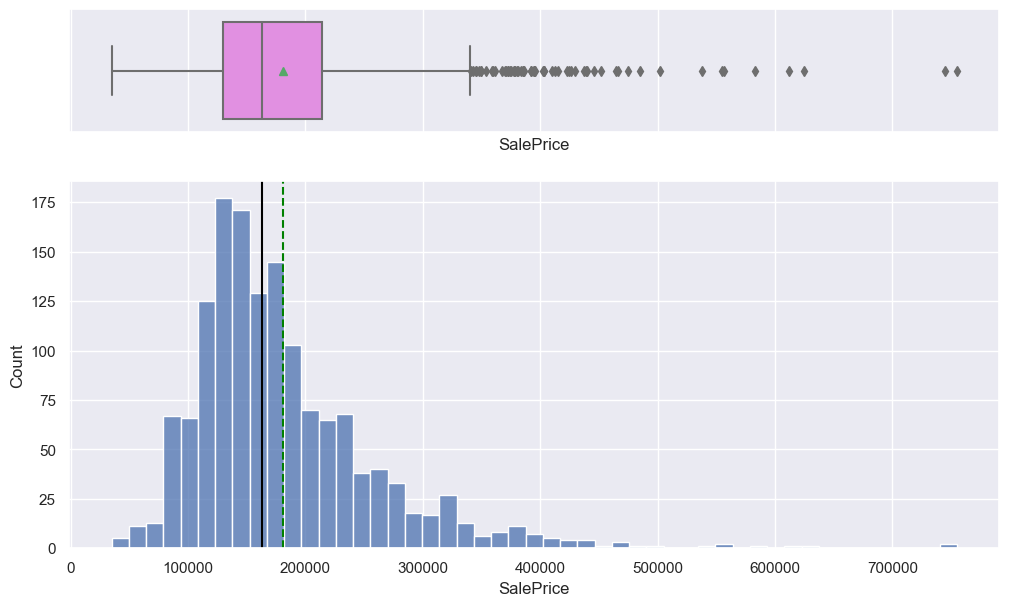

In [104]:
# inspecting dependent saleprice distribution
histogram_boxplot(Y,'SalePrice')

**Observations**

* Saleprice data is skewed
* Perform a log transform to reduce skewness and check if it helps normalize the distribution

In [105]:
# Applying natural log to the sales price since it is left skewed

Y['Log_SalePrice'] = np.log(Y['SalePrice'])

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_89160/2763340114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Log_SalePrice'] = np.log(Y['SalePrice'])


**Outlier Detection Using Boxplots**

**Observations**

* `LotFrontage`, `LotArea`, `MasVnrArea`, `BsmtFinSF2`, `GarageArea`, and `ScreenPorch` have prominent upper outliers
* `YearBuilt` appears to have some lower outliers
* `OverallCond`, `BedroomAbvGr`, and `GarageYrBlt` have both upper and lower outliers

Removing Outliers using the box plot, removing the whiskers
The above function will identify outliers that we define as being above or below the 75th and 25th quartiles and will impute them with the values of the upper and lower boxplot whiskers

In [106]:

def treat_outliers(df, col, lower_quantile=0.25, upper_quantile=0.75, whisker_multiplier=1.5):
    Q1 = df[col].quantile(lower_quantile)
    Q3 = df[col].quantile(upper_quantile)
    IQR = Q3 - Q1
    lower_whisker = Q1 - whisker_multiplier * IQR
    upper_whisker = Q3 + whisker_multiplier * IQR

    # Clip the outliers
    df[col] = df[col].clip(lower_whisker, upper_whisker)

    return df

def treat_outliers_all(df, col_list, lower_quantile=0.25, upper_quantile=0.75, whisker_multiplier=1.5):

    for col in col_list:
        df = treat_outliers(df, col, lower_quantile, upper_quantile, whisker_multiplier)

    return df

numerical_col = traincombined.loc[:,traincombined.columns != 'Training'].select_dtypes(exclude='object').columns.tolist()
train_final = treat_outliers_all(traincombined,numerical_col)

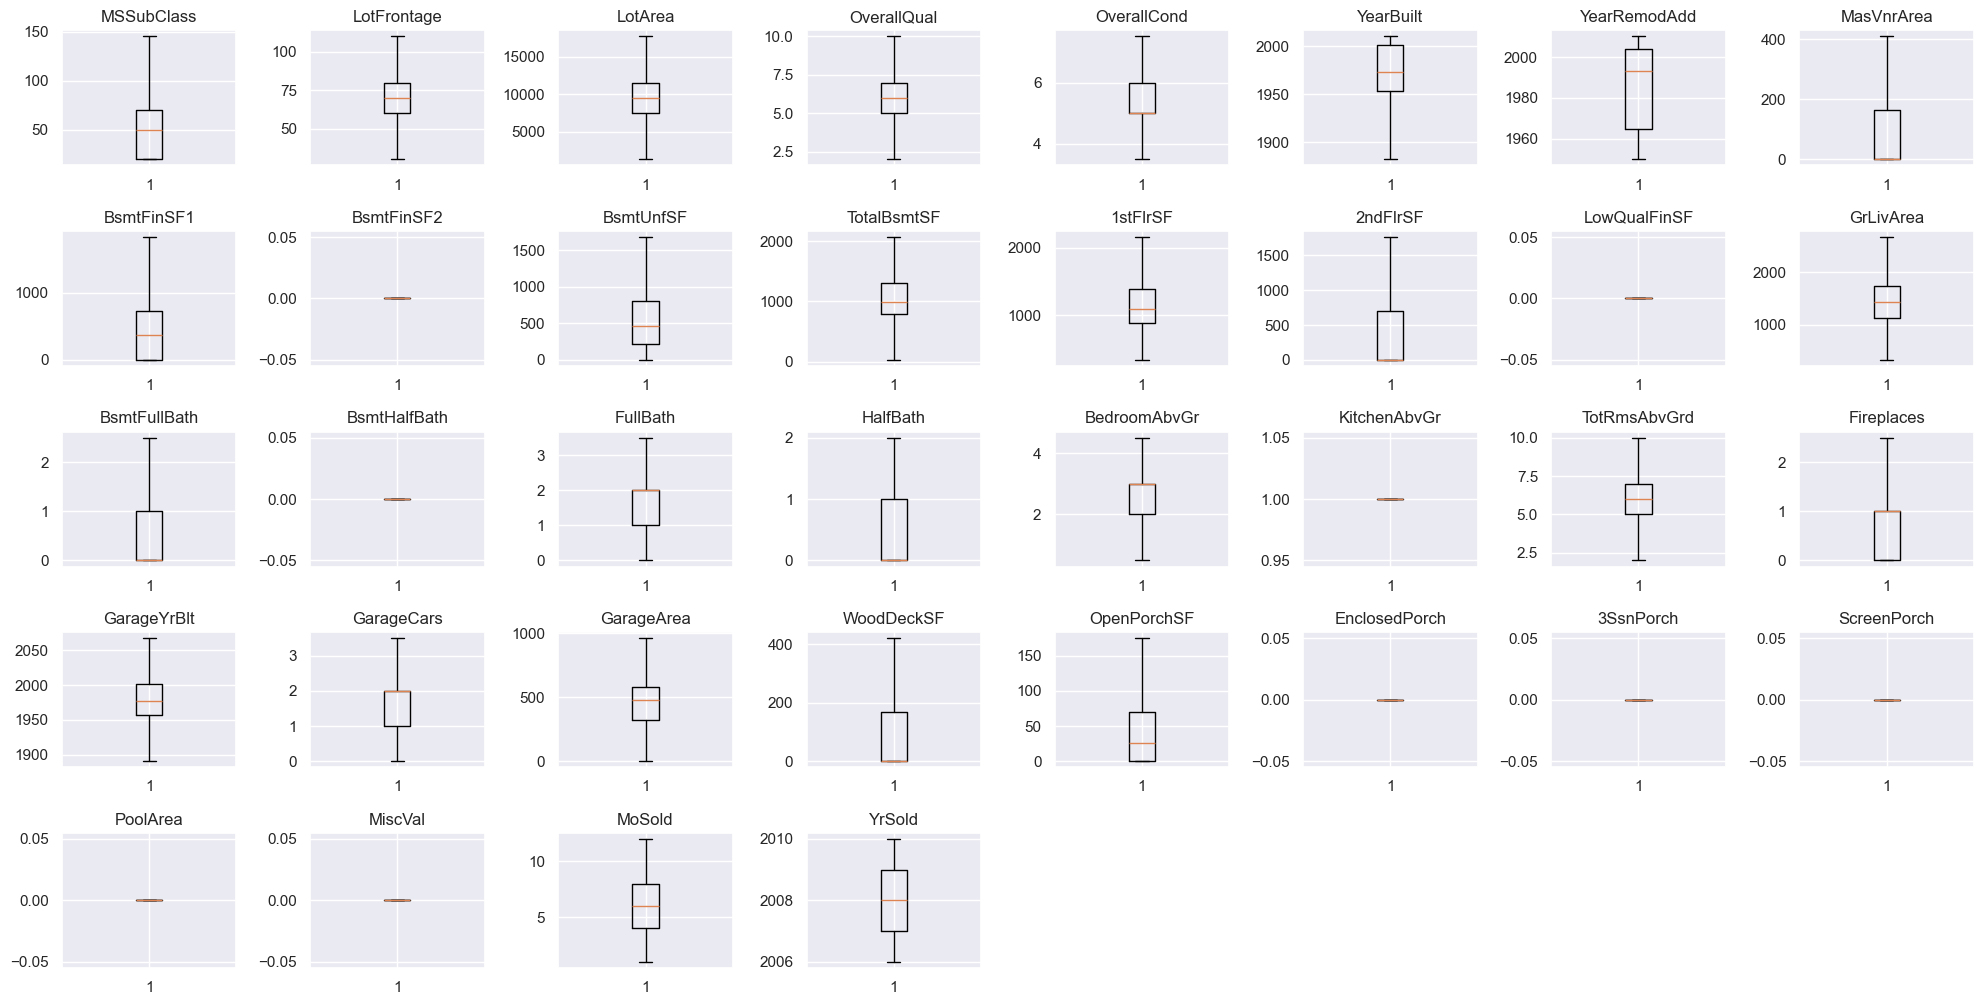

In [107]:
plt.figure(figsize=(20,30))

for i,variable in enumerate(numerical_col):
    plt.subplot(15,8,i+1) 
    plt.boxplot(train_final[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()   

Looking at the boxplots again we can see that the outliers have been treated

### Summary of EDA + Preprocessing

**Data Description**

* The target dependent variable `SalePrice` is of *float* type
* All other fields are of *object*, *float*, and *int* types
* The train and test data sets are combined to speed up the process of data cleaning and outlier treatments
* `ID` field is dropped as it serves no purposes in model training, values are saved to seperate variables
* There missing values in the data. Fields with missing data have been filled using most frequent imputation, median imputation, and context provided by the data dictionary


**Observations from EDA**

* The dependent variable `SalePrice` showed signs of right skewness. Log transform was applied to normalize the values and reduce the skew
* Majority of the features showed signs of outliers. A custom function was applied to treat all outliers falling above or below the 75th and 25th quartiles

## Model Building

1. We need to predict the housing saleprices. Since `SalePrice` is a skewed variable we will build the model using both the actual and transformed log version
2. Need to explore Lasso and Ridge regression techniques
3. We will build an initial model using simple linear regression and compare the performance against Lasso and Ridge to determine the best option 

### Define independent and dependent variables

In [108]:
X = train_final[train_final['Training'] == 1].drop(columns=['Training'])
y = Y["SalePrice"]

# Define the test data (X_test)
X_test = train_final[train_final['Training'] == 0].drop(columns=['Training'])

# Verify the shapes of the resulting dataframes
print(f"Training features shape: {X.shape}")
print(f"Training target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (1460, 79)
Training target shape: (1460,)
Test features shape: (1459, 79)


### Encoding Categorical Fields

In [109]:
categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align the training set with the test set, ensuring they have the same columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_No Alley Access,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No Basement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No Basement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No Basement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No Basement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No Basement,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No Fireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_No Garage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No Garage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No Pool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,Sal

### Lasso Regression 

* Using Metric functions defined in Sklearn for RMSE, MAPE, and $R^2$
* Creating a function that will print all metrics in a single execution which will be called upon for all models

In [110]:
# Redefining the dependent and independent variables

y = Y['Log_SalePrice']
x_train3, x_test3, y_train3, y_test3 = train_test_split(
    X, y, test_size=0.25, random_state=69
)

print("Number of rows in train data =", x_train3.shape[0])
print("Number of rows in test data =", x_test3.shape[0])


Number of rows in train data = 1095
Number of rows in test data = 365


**Cross Validation to Determine Optimal Alpha**

In [111]:
# Create and fit the Lasso regression model with cross-validation


lasso_cv_model = LassoCV(cv=10, random_state=0)
lasso_cv_model.fit(x_train3, y_train3)

# Get the best alpha
best_alpha = lasso_cv_model.alpha_
print(f'Best alpha: {best_alpha}')

Best alpha: 0.6361517606105984


In [112]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# Fitting a Lasso model with the best alpha
lassomodel = Lasso(alpha=best_alpha)
lassomodel.fit(x_train3, y_train3)

# Function to get coefficients and intercept as a DataFrame
def get_coefficients_dataframe(model, feature_names):
    coefficients = np.append(model.coef_, model.intercept_)
    coef_df = pd.DataFrame(
        coefficients,
        index=feature_names + ["Intercept"],
        columns=["Coefficients"]
    )
    return coef_df

def adj_r2_score(predictors, targets, predictions):
    """
    Calculate adjusted R-squared.
    """
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

def mape_score(targets, predictions):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    """
    # Protect against division by zero
    return np.mean(np.abs((targets - predictions) / np.where(targets == 0, 1, targets))) * 100

def model_performance_regression(model, predictors, target):
    """
    Evaluate model performance using several regression metrics.
    """
    pred = model.predict(predictors)
    r2 = r2_score(target, pred)
    adjr2 = adj_r2_score(predictors, target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    mape = mape_score(target, pred)

    df_perf = pd.DataFrame(
        {
            "RMSE": [rmse],
            "MAE": [mae],
            "R-squared": [r2],
            "Adj. R-squared": [adjr2],
            "MAPE": [mape],
        }
    )
    return df_perf

# Get the coefficients DataFrame for the Lasso model
coef_df3 = get_coefficients_dataframe(lassomodel, x_train3.columns.tolist())

# Display the top 10 coefficients by absolute value
top_10_coef = coef_df3.reindex(coef_df3['Coefficients'].abs().sort_values(ascending=False).index).head(10)
print("Top 10 Features by Absolute Coefficient Value:")
print(top_10_coef)

# Checking model performance on the train set using the Lasso model
print("Training Performance:")
lasso_model_perf_train = model_performance_regression(lassomodel, x_train3, y_train3)
print(lasso_model_perf_train)

print("TEst Performance:")
lasso_model_perf_train = model_performance_regression(lassomodel, x_test3, y_test3)
print(lasso_model_perf_train)

Top 10 Features by Absolute Coefficient Value:
              Coefficients
Intercept         2.260101
YearBuilt         0.002128
YearRemodAdd      0.001820
GarageYrBlt       0.000476
GarageArea        0.000274
TotalBsmtSF       0.000252
2ndFlrSF          0.000229
1stFlrSF          0.000156
GrLivArea         0.000143
BsmtFinSF1        0.000094
Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.165513  0.114426   0.830775        0.778284  0.958611
TEst Performance:
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.175436  0.114682   0.797603        0.298357  0.958005


### Ridge Regression

In [113]:
# redefining the dependent and independent variables

# splitting the data in 70:30 ratio for train to test data
y = Y['Log_SalePrice']
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.3, random_state=69
)

# Create and fit the Ridge regression model with cross-validation

ridge_model = RidgeCV(cv=10)
ridge_model.fit(x_train2, y_train2)

# fitting a ridge model
lin_reg_model4 = Ridge(alpha=best_alpha)
lin_reg_model4.fit(x_train2, y_train2)

# Get the best alpha
best_alpha = ridge_model.alpha_
print(f'Best alpha: {best_alpha}')

# Get the coefficients DataFrame for the Lasso model
coef_df3 = get_coefficients_dataframe(ridge_model, x_train3.columns.tolist())

# Display the top 10 coefficients by absolute value
top_10_coef = coef_df3.reindex(coef_df3['Coefficients'].abs().sort_values(ascending=False).index).head(10)
print("Top 10 Features by Absolute Coefficient Value:")
print(top_10_coef)

# Checking model performance on the train set using the Lasso model
print("Training Performance:")
lasso_model_perf_train = model_performance_regression(ridge_model, x_train2, y_train2)
print(lasso_model_perf_train)

# Checking model performance on test set
print("Test Performance:")
lin_reg_model4_perf_test = model_performance_regression(ridge_model, x_test2, y_test2)
lin_reg_model4_perf_test

Best alpha: 10.0
Top 10 Features by Absolute Coefficient Value:
                      Coefficients
Intercept                15.328836
PoolQC_Gd                -0.090006
Neighborhood_Crawfor      0.086168
Functional_Typ            0.074502
MSZoning_RL               0.062749
MSZoning_FV               0.061139
RoofMatl_WdShngl          0.061087
CentralAir_Y              0.059758
PoolQC_No Pool            0.059309
Neighborhood_MeadowV     -0.058422
Training Performance:
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.103462  0.072771   0.934666        0.912459  0.610141
Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.133232,0.081396,0.880782,0.707312,0.681


## Predictions

In [115]:
predictions_ridge = ridge_model.predict(X_test)
#undoing log transformation in order to get real valued house prices 

predictions_ridge = np.exp(predictions_ridge)
ridge = pd.DataFrame({'Id':test_id.to_list(),'SalePrice':predictions_ridge.tolist()})
ridge.to_csv('submission.csv',index = False)
